In [2]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer

finwiz_url = 'https://finviz.com/quote.ashx?t='

In [14]:
news_tables = {}
tickers = ['CLOV', 'TSLA', 'HOFV']

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    response = urlopen(req)    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table

In [13]:
# Read one single day of headlines for AMZN
clov = news_tables['CLOV']

# Get all table rows tagged in HTML with <tr> into 'amzn_tr
clov_tr = clov.findAll('tr')

for i, table_row in enumerate(clov_tr):
    # Read the text of the element 'a' into 'link_text'
    a_text = table_row.a.text
    # Read the text of the element 'td' into 'data_text'
    td_text = table_row.td.text
    # Print the contents of 'link_text' and 'data_text' 
    print(a_text)
    print(td_text)
    # Exit after printing 4 rows of data
    if i == 3:
        break


SHAREHOLDER ALERT: IRTC CLOV LDOS: The Law Offices of Vincent Wong Reminds Investors of Important Class Action Deadlines
Mar-25-21 07:15AM  
CLASS ACTION UPDATE for BLU, CLOV and APA: Levi & Korsinsky, LLP Reminds Investors of Class Actions on Behalf of Shareholders
06:30AM  
FINAL DEADLINE IMMINENT: The Schall Law Firm Announces That A Class Action Lawsuit Has Been Filed Against Clover Health Investments, Corp. and Encourages Investors with Losses in Excess of $100,000 to Contact the Firm
12:40AM  
SHAREHOLDER ALERT BY FORMER LOUISIANA ATTORNEY GENERAL: KSF REMINDS CLOV, IRTC INVESTORS of Lead Plaintiff Deadline in Class Action Lawsuits
Mar-24-21 10:49PM  


In [15]:
# parse date, time, news headline into python list
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])
        
parsed_news

ad Plaintiff Deadline is April 6, 2021'],
 ['CLOV',
  'Mar-16-21',
  '11:01AM',
  'SHAREHOLDER ALERT: Levi & Korsinsky, LLP Notifies Shareholders of Clover Health Investments, Corp. of a Class Action Lawsuit and a Lead Plaintiff Deadline of April 6, 2021 - CLOV'],
 ['CLOV',
  'Mar-16-21',
  '11:00AM',
  'DEADLINE ALERT for JFU, IRTC, TSN, CLOV: Law Offices of Howard G. Smith Reminds Investors of Class Actions on Behalf of Shareholders'],
 ['CLOV',
  'Mar-16-21',
  '11:00AM',
  'CLOV, BLUE & EH Class Actions: Bronstein, Gewirtz & Grossman LLC Reminds Shareholders of Class Actions and Encourages Investors to Contact the Firm'],
 ['CLOV',
  'Mar-16-21',
  '09:05AM',
  'LAWSUIT FILED: Block & Leviton LLP Has Filed a Lawsuit Against Clover Health Investments, Corp. for Securities Fraud; Investors Who Lost Money Should Contact the Firm'],
 ['CLOV',
  'Mar-16-21',
  '09:00AM',
  'CLOVER INVESTORS: April 6, 2021 Filing Deadline in Class Action - Contact Lieff Cabraser'],
 ['CLOV',
  'Mar-16-21

In [16]:
vader = SentimentIntensityAnalyzer()

# set column names
columns = ['ticker', 'date', 'time', 'headline']

# store parsed_news into dataframe
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,CLOV,2021-03-25,07:15AM,SHAREHOLDER ALERT: IRTC CLOV LDOS: The Law Off...,0.000,0.772,0.228,0.5766
1,CLOV,2021-03-25,06:30AM,"CLASS ACTION UPDATE for BLU, CLOV and APA: Lev...",0.000,1.000,0.000,0.0000
2,CLOV,2021-03-25,12:40AM,FINAL DEADLINE IMMINENT: The Schall Law Firm A...,0.123,0.800,0.077,-0.1779
3,CLOV,2021-03-24,10:49PM,SHAREHOLDER ALERT BY FORMER LOUISIANA ATTORNEY...,0.071,0.799,0.130,0.3254
4,CLOV,2021-03-24,09:30PM,Pomerantz Law Firm Announces the Filing of a C...,0.000,0.937,0.063,0.2732


In [ ]:
# compund scores gives sentiment scores

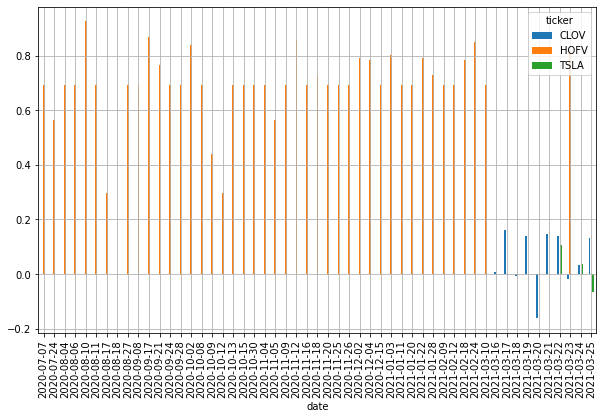

In [17]:
plt.rcParams['figure.figsize'] = [10, 6]

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()

In [ ]:
"""
The ‘compound’ column gives the sentiment scores. For positive scores, the higher the value, the more positive the sentiment is. Similarly for negative scores, the more negative the value, the more negative the sentiment is. The scores range from -1 to 1.
"""